In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# load the session
race = fastf1.get_session(2023, 'Spain', 'R')
race.load()

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\abdul\AppData\Local\Temp\fastf1.
	Size: 588.65 MB
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.1.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api   

In [3]:
# get laps for Hamilton and Leclerc
ham_laps = race.laps.pick_driver('HAM').reset_index()
lec_laps = race.laps.pick_driver('LEC').reset_index()

In [4]:
def data_pre_processing(df):
    '''
    This function takes in a dataframe and converts the time columns to seconds, replace nan values, and adds a new columns

    Parameters:
    df (dataframe): dataframe to be processed

    Returns:
    df (dataframe): processed dataframe
    '''
    # convert the time columns to seconds
    convert_to_seconds = lambda x: x.total_seconds() if pd.Timedelta == type(x) else x
    df = df.applymap(convert_to_seconds)
    # replace nan values with None
    df.replace({np.nan: None}, inplace=True)
    # set a new column "Pit" to True if the PitOutTime is not null or PitInTime is not null
    df['Pit'] = df['PitOutTime'].notnull() | df['PitInTime'].notnull()
    return df

In [5]:
# process the dataframes with driver laps using the function
ham_laps = data_pre_processing(ham_laps)
lec_laps = data_pre_processing(lec_laps)

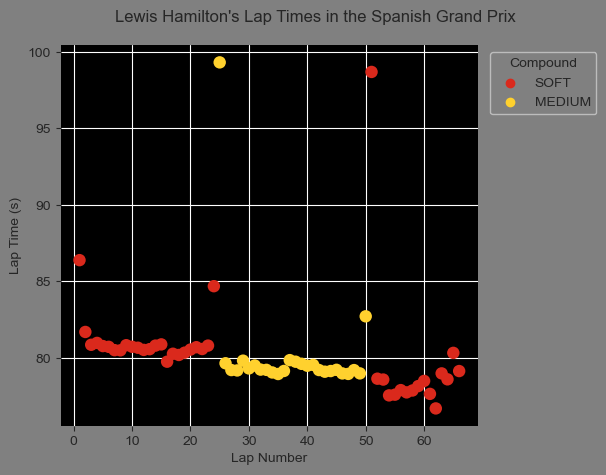

In [6]:
# set the background to be black so that tire colors are prominent
sns.set_style("ticks", rc = {"axes.facecolor": "black", "figure.facecolor": "grey"})
fig, ax = plt.subplots()
# scatter plot of lap times
sns.scatterplot(data = ham_laps, x = "LapNumber", y = "LapTime",
                ax = ax, hue = "Compound", palette = fastf1.plotting.COMPOUND_COLORS,
                s = 80, linewidth = 0, legend = "auto")
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time (s)")
plt.suptitle(f"Lewis Hamilton's Lap Times in the {race.event.EventName}")
plt.grid(color = "w", which = 'major', axis = 'both')
sns.despine(left = True, bottom = True)
# get the plot's legend
leg = ax.get_legend()
# put the legend out of the plot
leg.set_bbox_to_anchor((1.3, 1))
# set the legend's background to transparent
frame = leg.get_frame()
frame.set_facecolor('none')
plt.tight_layout()
plt.show()

In [7]:
# merge the two dataframes
combined_dataframe = pd.merge(ham_laps, lec_laps, on='LapNumber', suffixes=('_HAM', '_LEC'))

# Calculate the lap time difference between HAM and LEC
combined_dataframe['LapTimeDifference'] = combined_dataframe['LapTime_HAM'] - combined_dataframe['LapTime_LEC']

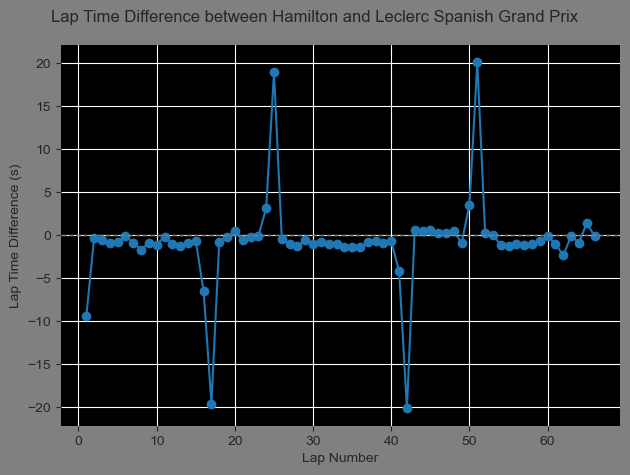

Recommendation: Consider pitting on laps [65.0] for a strategic advantage.


In [8]:
# Plot lap time difference
fig, ax_diff = plt.subplots()
ax_diff.plot(ham_laps['LapNumber'], combined_dataframe['LapTimeDifference'], marker='o')
ax_diff.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Equal Lap Time')

ax_diff.set_xlabel("Lap Number")
ax_diff.set_ylabel("Lap Time Difference (s)")
plt.suptitle(f"Lap Time Difference between Hamilton and Leclerc {race.event.EventName}")
plt.grid(color="w", which='major', axis='both')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# find the laps that Hamilton and Leclerc pitted
ham_pit_laps = ham_laps[ham_laps['Pit'] == True].LapNumber.values
lec_pit_laps = lec_laps[lec_laps['Pit'] == True].LapNumber.values

# Identify when to pit based on lap time difference
threshold_time_difference = 1  # Set your threshold for pitting
pit_indices = combined_dataframe[combined_dataframe['LapTimeDifference'] > threshold_time_difference].LapNumber
# remove pit laps from pit indices
pit_indices = pit_indices[~pit_indices.isin(ham_pit_laps)]
pit_indices = pit_indices[~pit_indices.isin(lec_pit_laps)]

if not pit_indices.empty:
    print(f"Recommendation: Consider pitting on laps {pit_indices.values.tolist()} for a strategic advantage.")
else:
    print("No clear advantage gained by pitting based on current lap time difference.")

In [9]:
# take the color of the two teams
ham_color = fastf1.plotting.team_color("Mer")
lec_color = fastf1.plotting.team_color("Fer")

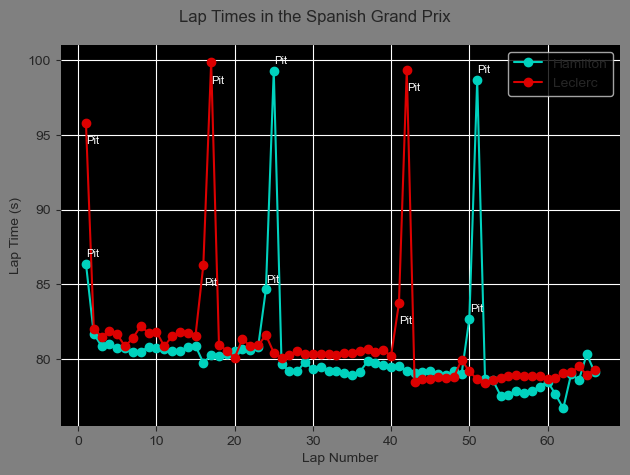

In [10]:
# Plot Hamilton's lap times as a line plot with pit annotations
fig, ax = plt.subplots()
ax.plot(ham_laps['LapNumber'], ham_laps['LapTime'], marker='o', color=ham_color, label='Hamilton')
ax.plot(lec_laps['LapNumber'], lec_laps['LapTime'], marker='o', color=lec_color, label='Leclerc')

# Annotate pit laps for Hamilton
for lap in ham_pit_laps:
    ax.annotate('Pit', xy=(lap, ham_laps.loc[ham_laps['LapNumber'] == lap, 'LapTime'].values[0]),
                xytext=(5, 5), textcoords='offset points', color='white', fontsize=8, ha='center')

# Annotate pit laps for Leclerc
for lap in lec_pit_laps:
    ax.annotate('Pit', xy=(lap, lec_laps.loc[lec_laps['LapNumber'] == lap, 'LapTime'].values[0]),
                xytext=(5, -15), textcoords='offset points', color='white', fontsize=8, ha='center')

ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time (s)")
plt.suptitle(f"Lap Times in the {race.event.EventName}")
plt.grid(color="w", which='major', axis='both')
sns.despine(left=True, bottom=True)
plt.legend()
plt.tight_layout()
plt.show()